In [1]:
import numpy as np
import pandas as pd

from fastai.vision.all import *

import albumentations as Alb

* albumentations
    * image augmentation in pytorch

In [2]:
INPUT_PATH = '../input/paddy-disease-classification'
TRAIN_PATH = INPUT_PATH + '/train_images'
TEST_PATH = INPUT_PATH + '/test_images'

In [3]:
# 이미지 증식
class AlbTransform(Transform):
    def __init__(self, aug):
        self.aug = aug

    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def get_augs():
    return Alb.Compose([
        Alb.ShiftScaleRotate(rotate_limit=20, border_mode=0),
        Alb.Transpose(),
        Alb.Flip(),
        Alb.RandomRotate90(),
        Alb.RandomBrightnessContrast(),
        Alb.HueSaturationValue(
            hue_shift_limit=5,
            sat_shift_limit=5,
            val_shift_limit=5
        )
    ])

item_tfms = [Resize(224), AlbTransform(get_augs())]
batch_tfms = Normalize.from_stats(*imagenet_stats)

In [4]:
# create datalodaer from the folder structure
dls = ImageDataLoaders.from_folder(
    TRAIN_PATH,
    train='.',
    valid=None,
    valid_pct=0.01,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
    bs=64,
    shuffle=True
)

In [5]:
print('train items:', len(dls.train.items), 'validation items:', len(dls.valid.items))
dls.vocab

train items: 10303 validation items: 104


['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

* vision_learner
    * https://docs.fast.ai/vision.learner.html#vision_learner
    * resnet50
    * loss func - FocalLoss
        * crossentropy의 클래스 불균형 문제 다루기 위한 개선된 버전
        * 어렵거나 쉽게 오분류되는 케이스에 대하여 더 큰 가중치를 주는 방법
        * Cross Entropy Loss 잘못 예측한 경우에 대하여 페널티 부여하는 것에 초점
        * https://gaussian37.github.io/dl-concept-focal_loss/

In [6]:
learn = vision_learner(
    dls,
    resnet101,
    path='.',
    loss_func=FocalLoss(),
    metrics=[accuracy]
)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.994870,1.009510,0.538462,03:01
1,1.639325,0.722166,0.625000,02:40
2,1.405976,0.654508,0.634615,02:38
3,1.285575,0.749452,0.615385,02:38
4,1.130543,0.749885,0.653846,02:39
5,1.016439,0.616407,0.740385,02:40
6,0.931972,0.621362,0.692308,02:39
7,0.852297,0.589530,0.750000,02:39
8,0.774128,0.404518,0.817308,02:39
9,0.683587,0.404548,0.807692,02:39


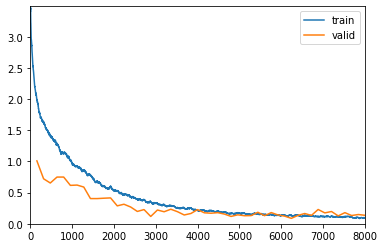

epoch,train_loss,valid_loss,accuracy,time
0,0.097852,0.112334,0.961538,02:50
1,0.082349,0.107712,0.932692,02:49
2,0.088960,0.177302,0.942308,02:50
3,0.109240,0.156274,0.942308,02:49
4,0.107576,0.155593,0.942308,02:49
5,0.141445,0.099176,0.942308,02:47
6,0.137245,0.151021,0.913462,02:49
7,0.120431,0.170125,0.942308,02:48
8,0.123794,0.208202,0.894231,02:50
9,0.117504,0.176948,0.942308,02:49


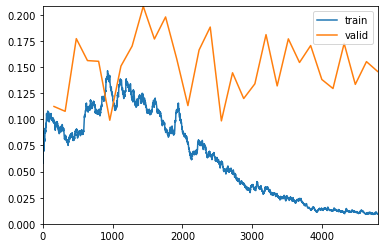

In [7]:
learn.fine_tune(30, freeze_epochs=50, cbs=[ShowGraphCallback()])

In [8]:
ftest = get_image_files(TEST_PATH)
print('Testing', len(ftest), 'items')

Testing 3469 items


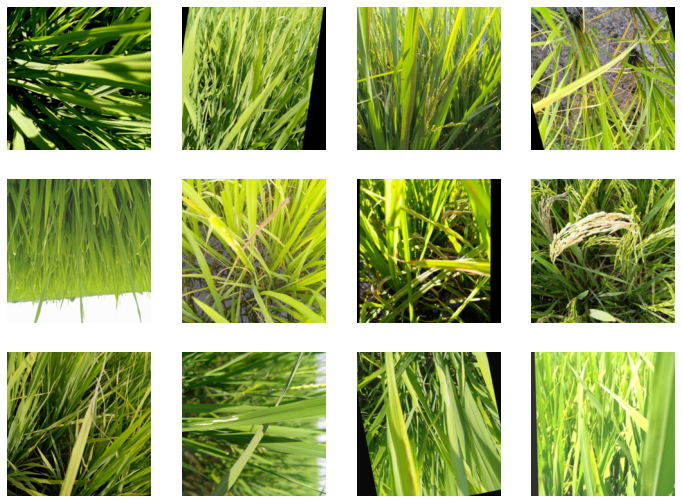

In [9]:
# make dataloader for test data
tst_dl = dls.test_dl(ftest, with_labels=False, shuffle=False)
tst_dl.show_batch(max_n=12)

* Learner.tta(ds_idx=1, dl=None, n=4, item_tfms=None, batch_tfms=None, beta=0.25, use_max=False)
    * Return predictions on the ds_idx dataset or dl using Test Time Augmentation
    * prediction *n* times with the transforms of the training set and average those.
    * The final predictions are *(1-beta)* multiplied by this average + *beta* multiplied by the predictions obtained with the transforms of the dataset

In [10]:
%%time

preds = learn.tta(dl=tst_dl, n=32, use_max=False)

CPU times: user 3min 44s, sys: 7.72 s, total: 3min 52s
Wall time: 25min 42s


In [11]:
predss = learn.dls.vocab[np.argmax(preds[0], axis=1)]
subm_df = pd.DataFrame()
subm_df['image_id'] = [item.name for item in tst_dl.items]
subm_df['label'] = predss
subm_df.to_csv('submission.csv', header=True, index=False)